# AWS Summit San Francisco 2022
## Using AWS Inferentia to optimize HuggingFace model inference

Welcome to the AWS Summit San Francisco 2022 Inferentia Workshop! 


# Table of contents
1. [Introduction](#introduction)
2. [Setting up the environment](#setenv)
3. [Get model from HuggingFace Model Hub](#getmodel)
    1. [Get the Tokenizer](#gettoken)
    2. [Download models and prepare them for inference](#trace)
4. [Deploy default model to a CPU-based endpoint](#deploycpu)
    1. [Perform a test CPU based inference](#testcpu)
5. [Compile and deploy the model on an Inferentia instance](#compiledeploy)
    1. [Review changes to the inference code](#reviewchanges)
    2. [Create and compile Pytorch model for the inf1 instance](#pytorchmodel)
    3. [Deploy compiled model into the inf1 instance](#deployinf1)
    4. [Perform a test inf1 based inference](#testinf1)
6. [Benchmark and comparison](#benchmark)
    1. [Benchmark CPU based endpoint](#benchcpu)
    2. [Benchmark Inferentia based endpoint](#benchinf1)
    3. [Comparison and conclusions](#conclusions)
7. [Cleanup](#cleanup)

---

# Introduction <a name="introduction"></a>

During this workshop, we will deploy two HuggingFace NLP models for the task of paraphrase detection on SageMaker endpoints. Paraphrase detection is an NLP classification problem. Given a pair of sentences, the system determines. the semantic similarity between the two sentences. If the two sentences convey the same meaning it is labelled as paraphrase, otherwise it is labeled as non-paraphrase. We will use `distilbert-base-uncased` [DistilBERT](https://huggingface.co/distilbert-base-uncased) transfromer model from HuggingFace Model Hub. 
These two models will be deployed in different endpoints: a CPU-based endpoint, with no changes to the model; and the other will be compiled on SageMaker and deployed to an Inf1 instance based endpoint. Finally, we will perform a latency and throughput performance comparison of both endpoints. 

[AWS Inferentia](https://aws.amazon.com/machine-learning/inferentia/) is Amazon's first custom silicon designed to accelerate deep learning workloads and is part of a long-term strategy to deliver on this vision. AWS Inferentia is designed to provide high performance inference in the cloud, to drive down the total cost of inference, and to make it easy for developers to integrate machine learning into their business applications. AWS Inferentia chips deliver up 2.3x higher throughput and up to 70% lower cost per inference than comparable current generation GPU-based Amazon EC2 instances, as we will confirm in the example notebook.

[AWS Neuron](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/) is a software development kit (SDK) for running machine learning inference using AWS Inferentia chips. It consists of a compiler, run-time, and profiling tools that enable developers to run high-performance and low latency inference using AWS Inferentia-based Amazon EC2 Inf1 instances. Using Neuron, you can bring your models that have been trained on any popular framework (PyTorch, TensorFlow, MXNet), and run them optimally on Inferentia. There is excellent support for Vision and NLP models especially, and on top of that we have released great features to help you make the most efficient use of the hardware, such as [dynamic batching](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/appnotes/perf/torch-neuron-dataparallel-app-note.html#dynamic-batching-description) or [Data Parallel](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-torch-neuron-dataparallel-api.html) inferencing.

[SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) saves you the effort of DIY model compilation, extending familiar SageMaker SDK API's to enable easy compilation for a [wide range](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents) of platforms. This includes CPU and GPU-based instances, but also Inf1 instances; in this case, SageMaker Neo uses the Neuron SDK to compile your model.


---

## Getting Started  <a name="setenv"></a>
### Setting up the environment

We install required Python packages. Also, we will create a default Amazon Sagemaker session, get the Amazon Sagemaker role and default Amazon S3 bucket.

In [1]:
%%capture
!pip install -U transformers
!pip install -U sagemaker
!pip install -U torch

In [2]:
import sys
import transformers
import sagemaker
import torch
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sess_bucket = sagemaker_session.default_bucket()

---

## Get model from HuggingFace Model Hub <a name="getmodel"></a>

For this workshop, we chose one of the most downloaded models from the HuggingFace Model Hub: `distilbert-base-uncased`. [DistilBERT](https://huggingface.co/distilbert-base-uncased). It is a transformer model, smaller and faster than BERT, which was pretrained on the same data as BERT, which is BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).

### Get the Tokenizer <a name="gettoken"></a>
As a first step, we need to get the tokenizer. A tokenizer breaks a stream of text into tokens, and it is in charge of preparing the inputs for a model. We need it to create a sample input to interact with the Distillibert model, and will get it from HuggingFace through the `transformers` library. It is important to set the `return_dict` parameter to `False` when instantiating the model. In `transformers` v4.x, this parameter is `True` by default and it enables the return of dict-like python objects containing the model outputs, instead of the standard tuples. Neuron compilation does not support dictionary-based model ouputs, and compilation would fail if we didn't explictly set it to `False`.

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", return_dict=False
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

### Download models and prepare them for inference <a name="trace"></a>
We will download the model and create two files with different formats. The first one is the model itself with no changes. This one will be uploaded and used in the CPU based endpoint as it is. The second image is a traced Pytorch image of the model so we can compile it before deploying it to the inf1 instance.

PyTorch models must be saved as a definition file (.pt or .pth) with input datatype of float32.
To save the model, we will use torch.jit.trace followed by torch.save. This will save an object to a file ( a python pickle: pickle_module=pickle). 

Next, we will convert the saved model to a compressed tar file and upload it to an S3 bucket.
As a final step, we will create a sample input to `jit.trace` of the model with PyTorch. We need this to have SageMaker Neo compile the model artifact.


In [4]:
from pathlib import Path

# Create directory for model artifacts
Path("normal_model/").mkdir(exist_ok=True)
Path("traced_model/").mkdir(exist_ok=True)

# Prepare sample input for jit model tracing
seq_0 = "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances."
seq_1 = seq_0
max_length = 512

tokenized_sequence_pair = tokenizer.encode_plus(
    seq_0, seq_1, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)

example = tokenized_sequence_pair["input_ids"], tokenized_sequence_pair["attention_mask"]

traced_model = torch.jit.trace(model.eval(), example)

model.save_pretrained('normal_model/')
traced_model.save("traced_model/model.pth") # The `.pth` extension is required.

[2022-04-14 18:28:57.781 pytorch-1-6-cpu-py36-u-ml-c5-large-c4a461fcfd95e65f0470c83bc031:1807 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-14 18:28:58.078 pytorch-1-6-cpu-py36-u-ml-c5-large-c4a461fcfd95e65f0470c83bc031:1807 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [5]:
!tar -czvf normal_model.tar.gz -C normal_model . && mv normal_model.tar.gz normal_model/
!tar -czvf traced_model.tar.gz -C traced_model . && mv traced_model.tar.gz traced_model/

./
./pytorch_model.bin
./config.json
./normal_model.tar.gz
./
./model.pth
./traced_model.tar.gz


We upload the traced model `tar.gz` file to Amazon S3, where the compilation job will download it from

In [6]:
normal_model_url = sagemaker_session.upload_data(
    path="normal_model/normal_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/normal-model",
)

traced_model_url = sagemaker_session.upload_data(
    path="traced_model/traced_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/traced-model",
)

---

## Deploy default model to a CPU-based endpoint <a name="deploycpu"></a>

We will be passing the `traced_model_url` as the `model_data` parameter to the `HuggingFaceModel` API. 
Notice that we are passing `inference.py` as the entry point script; also, the packages defined in the requirements file within the `source_dir` will automatically be installed in the endpoint instance. In this case we will use the `transformers` library that is compatible Inferentia instances (v. 4.15.0)

In [7]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.predictor import Predictor
from datetime import datetime

prefix = "neuron-experiments/bert-seq-classification"
flavour = "normal"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

normal_sm_model = HuggingFaceModel(
    model_data=normal_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference.py",
    source_dir="code",
    py_version="py38",
    name=f"{flavour}-distilbert-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

In [8]:
%%time
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

hardware = "c5"

normal_predictor = normal_sm_model.deploy(
    instance_type="ml.c5.xlarge",
    initial_instance_count=1,
    endpoint_name=f"distilbert-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: normal-distilbert-202204-1418-3145
INFO:sagemaker:Creating endpoint-config with name distilbert-c5-202204-1418-3145
INFO:sagemaker:Creating endpoint with name distilbert-c5-202204-1418-3145


-----!CPU times: user 1min 12s, sys: 18.3 s, total: 1min 30s
Wall time: 4min 19s


### Perform a test inference <a name="testcpu"></a> on CPU

We will perform a quick test to see if the endpoint is responding as expected. We will send sample sequences.

In [9]:
# Predict with model endpoint
client = boto3.client('sagemaker')

#let's make sure it is up und running first
status = ""
while status != 'InService':
    endpoint_response = client.describe_endpoint(EndpointName=f"distilbert-{hardware}-{date_string}")
    status = endpoint_response['EndpointStatus']


# Send a payload to the endpoint and recieve the inference
payload = seq_0, seq_1
normal_predictor.predict(payload)

['"BERT predicts that \\"Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances.\\" and \\"Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances.\\" are paraphrase"',
 'application/json']

---

## Compile and deploy the model on an Inferentia instance <a name="compiledeploy"></a>

In this section we will cover the compilation and deployment of the model into the inf1 instance. We will also review the changes in the inference code.

### Review inference code <a name="reviewchanges"></a>

If you open `inference.py` you will see a few functions: `model_fn` receives the model directory, is responsible for loading and returning the model -, `input_fn` and `output_fn` functions are in charge of pre-processing/checking content types of input and output to the endpoint - and a `predict_fn`, receives the outputs of `model_fn` and `input_fn` (meaning, the loaded model and the deserialized/pre-processed input data) and defines how the model will run inference.

In this case, notice that we will load the corresponding model depending on whether the function is deployed. `model_fn` will return a tuple containing both the model and its corresponding tokenizer. Both the model and the input data will be sent `.to(device)`, which can be a CPU or GPU.

Here is the code snippet of the `model_fn` function:


In [10]:
# %load -s model_fn code/inference.py
def model_fn(model_dir):
    tokenizer_init = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    compiled_model = os.path.exists(f'{model_dir}/model_neuron.pt')
    if compiled_model:
        import torch_neuron
        os.environ["NEURONCORE_GROUP_SIZES"] = "1"
        model = torch.jit.load(f'{model_dir}/model_neuron.pt')
    else: 
        model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    
    return (model, tokenizer_init)

### Create and compile Pytorch model for the inf1 instance <a name="pytorchmodel"></a>

We will now create a new `Huggingface` model that will use the `inference.py` file described above as its entry point script. 

In [11]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.predictor import Predictor
from datetime import datetime
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_inf1_model = HuggingFaceModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference.py",
    source_dir="code",
    py_version="py37",
    name=f"distilbert-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

We are ready to compile the model! Two additional notes:
* HuggingFace models should be compiled to `dtype` `int64`
* the format for `compiler_options` differs from the standard Python `dict` that you can use when compiling for "normal" instance types; for inferentia, you must provide a JSON string with CLI arguments, which correspond to the ones supported by the [Neuron Compiler](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html) (read more about `compiler_options` [here](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents))
Let's compile the model:

In [12]:
%%time
import json

hardware = "inf1"
compilation_job_name = f"distilbert-{hardware}-" + date_string

compiled_inf1_model = compiled_inf1_model.compile(
    target_instance_family=f"ml_{hardware}",
    input_shape={"input_ids": [1, 512], "attention_mask": [1, 512]},
    job_name=compilation_job_name,
    role=role,
    framework="pytorch",
    framework_version="1.9.1",
    output_path=f"s3://{sess_bucket}/{prefix}/neo-compilations19/{hardware}-model",
    compiler_options=json.dumps("--dtype int64"),
    compile_max_run=900,
)

INFO:sagemaker:Creating compilation-job with name: distilbert-inf1-202204-1418-3606


?????????????????????????????.........................................................................................................!CPU times: user 440 ms, sys: 45.4 ms, total: 485 ms
Wall time: 11min 28s


### Deploy compiled model into the inf1 instance <a name="deployinf1"></a>

After successful compilation, we deploy the new model to an inf1.xlarge instance.

In [13]:
%%time

date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_inf1_predictor = compiled_inf1_model.deploy(
    instance_type="ml.inf1.xlarge",
    initial_instance_count=1,
    endpoint_name=f"test-neo-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=False
)

INFO:sagemaker:Creating model with name: distilbert-202204-1418-3606
INFO:sagemaker:Creating endpoint-config with name test-neo-inf1-202204-1418-4734
INFO:sagemaker:Creating endpoint with name test-neo-inf1-202204-1418-4734


CPU times: user 8.71 s, sys: 1.68 s, total: 10.4 s
Wall time: 10.4 s


### Perform a test inference <a name="testinf1"></a>

As a final test, we first make sure the endpoint is up una running in a `InService` state, and then perform a simple inference sending two sequences of text and wait for the response.

In [15]:
# Predict with model endpoint
client = boto3.client('sagemaker')

#let's make sure it is up und running first
status = ""
while status != 'InService':
    endpoint_response = client.describe_endpoint(EndpointName=f"test-neo-{hardware}-{date_string}")
    status = endpoint_response['EndpointStatus']


# Send a payload to the endpoint and recieve the inference
payload = seq_0, seq_1
compiled_inf1_predictor.predict(payload)

'BERT predicts that "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." and "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." are not paraphrase'

---

## Benchmark and comparison <a name="benchmark"></a>

Now that we have both endpoints online, we will perform a benchmark using Python's `threading` module. In each benchmark, we start 5 threads that will each make 300 requests to the model endpoint. We measure the inference latency for each request, and we also measure the total time to finish the task, so that we can get an estimate of the request throughput/second.

### Benchmark CPU based endpoint <a name="benchcpu"></a>

In [16]:
%%time
# Run the benchmark 

import threading
import time

num_preds = 100
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = normal_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Wait for threads, get an estimate of total time
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 139875525318400 started
Thread 139875655603968 started
Thread 139875630425856 started
Thread 139875663996672 started
Thread 139875672389376 started
CPU times: user 1.02 s, sys: 37.5 ms, total: 1.05 s
Wall time: 1min 58s


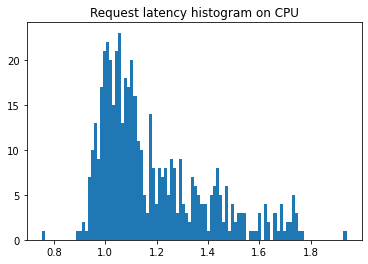

==== Default HuggingFace model on CPU benchmark ====

95 % of requests take less than 1638.5496139526365 ms
Rough request throughput/second is 4.218539492510314


In [17]:
# Display results 
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS_CPU = (num_preds * num_threads) / end

t_CPU = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t_CPU, q=[50, 90, 95, 99])
latency_CPU = latency_percentiles[2]*1000

hist(t_CPU, bins=100)
title("Request latency histogram on CPU")
show()

print("==== Default HuggingFace model on CPU benchmark ====\n")
print(f"95 % of requests take less than {latency_CPU} ms")
print(f"Rough request throughput/second is {TPS_CPU}")

We can see that request latency is in the 1-1.2 second range, and throughput is ~4.5 TPS.

### Benchmark Inferentia based endpoint <a name="benchinf1"></a>

In [18]:
%%time
# Run benchmark 

import threading
import time


num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = compiled_inf1_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Make a rough estimate of total time, wait for threads
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 139875630425856 started
Thread 139875655603968 startedThread 139875672389376 started

Thread 139875663996672 started
Thread 139875542103808 started
CPU times: user 2.01 s, sys: 133 ms, total: 2.14 s
Wall time: 9.09 s


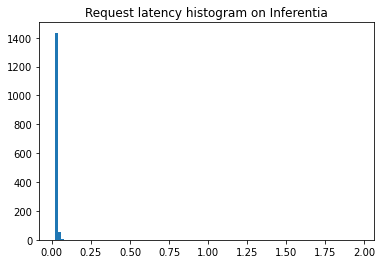

==== Default HuggingFace model on inf1 benchmark ====

95 % of requests take less than 36.66545152664183 ms
Rough request throughput/second is 165.22486837724384


In [19]:
# Display results 
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS_inf1 = (num_preds * num_threads) / end

t_inf1 = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t_inf1, q=[50, 90, 95, 99])
latency_inf1 = latency_percentiles[2]*1000

hist(t_inf1, bins=100)
title("Request latency histogram on Inferentia")
show()

print("==== Default HuggingFace model on inf1 benchmark ====\n")
print(f"95 % of requests take less than {latency_inf1} ms")
print(f"Rough request throughput/second is {TPS_inf1}")




We can see that request latency is in the 0.02-0.05 millisecond range, and throughput is ~157 TPS.

---

# Conclusion <a name="conclusions"></a>

In [20]:
print("Using inf1 instances latency dropped to a {:.2f} millisecond range from {:.2f} ms on a CPU endpoint.".format(latency_inf1, latency_CPU)) 
print("Also, The average throughput increased to {:.2f} TPS from {:.2f} TPS on the CPU.".format( TPS_inf1, TPS_CPU) )

Using inf1 instances latency dropped to a 36.67 millisecond range from 1638.55 ms on a CPU endpoint.
Also, The average throughput increased to 165.22 TPS from 4.22 TPS on the CPU.


This increase in performance obtained from using inf1 instances, paired with the cost reduction and the use of known SageMaker SDK APIs, enables new benefits with little development effort and a gentle learning curve. 

---

# Clean up <a name="cleanup"></a>
We delete the models and release the endpoints

In [21]:
normal_predictor.delete_model()
normal_predictor.delete_endpoint()
compiled_inf1_predictor.delete_model()
compiled_inf1_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: normal-distilbert-202204-1418-3145
INFO:sagemaker:Deleting endpoint configuration with name: distilbert-c5-202204-1418-3145
INFO:sagemaker:Deleting endpoint with name: distilbert-c5-202204-1418-3145
INFO:sagemaker:Deleting model with name: distilbert-202204-1418-3606
INFO:sagemaker:Deleting endpoint configuration with name: test-neo-inf1-202204-1418-4734
INFO:sagemaker:Deleting endpoint with name: test-neo-inf1-202204-1418-4734
